In [3]:
from pandas import read_csv, Series
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from pickle import load
from glove import Glove
import adagram
from gensim.models.wrappers import FastText, Wordrank
from embed_utils import Word2VecF, Swivel, cosine_sim, get_adagram_sense_prob, wv
from utils.string_utils import morph_parse, make_tokens

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.dummy import DummyClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import (accuracy_score, brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA

In [5]:
import matplotlib.pyplot as plt
import seaborn

In [30]:
def get_feature_vec(tokens, num_features, model):
    featureVec = np.zeros((num_features), dtype='float32')
    nwords = 0
    for word in tokens:
        if model == 'word2vec':
            featureVec = np.add(featureVec, word2vec[word])
        elif model == 'wang2vec':
            featureVec = np.add(featureVec, wang2vec[word])
        elif model == 'glove':
            featureVec = np.add(featureVec, wv(glove, word))
        elif model == 'word2vecf':
            featureVec = np.add(featureVec, w2vf.word2vec(word))
        elif model == 'adagram':
            featureVec = np.add(featureVec, ada_model.sense_vector(word, get_adagram_sense_prob(ada_model, word)))
        elif model == 'fasttext':
            featureVec = np.add(featureVec, ft[word])
        elif model == 'bow':
            featureVec = np.add(featureVec, bow[word])
        elif model == 'swivel':
            featureVec = np.add(featureVec, swivel.lookup(word))
        nwords = nwords + 1
    try:
        featureVec = np.divide(featureVec, nwords)
    except FloatingPointError:
         featureVec = np.zeros(shape=(1,num_features), dtype='float32')
    return featureVec

In [7]:
old_err_state = np.seterr(all='raise')

def vectorize_message(message1, message2, model, num_features, vocab):
    tokens1 = make_tokens(message1.lower(), vocab)
    tokens2 = make_tokens(message2.lower(), vocab)
    fv1 = get_feature_vec(tokens1, num_features, model)
    fv2 = get_feature_vec(tokens2, num_features, model)
    pca = PCA(n_components=1)
    try:
        return pca.fit_transform((np.stack((fv1, fv2)).T)).squeeze()
    except FloatingPointError:
        return np.zeros(shape=(num_features), dtype='float32')

In [8]:
df = read_csv('anno2ch/annotated.csv', encoding='cp1251')
df.comment = df.comment.apply(morph_parse)
df.reference = df.reference.apply(morph_parse)

In [9]:
df_unl = read_csv('anno2ch/annotated.csv', encoding='cp1251')

In [10]:
Y = df['labels'].values

In [11]:
from collections import Counter
Counter(Y)

Counter({0.0: 781, 1.0: 739})

Загрузка Word2Vec-модели

In [12]:
#word2vec = Word2Vec.load('models/2ch_word2vec')
#word2vec_vocab = word2vec.wv.vocab

word2vec = Word2Vec.load('models/2ch_word2vec_all_lem')
word2vec_vocab = word2vec.wv.vocab

Загрузка Glove-модели

In [13]:
with open('models/2ch_glove_all_lem_100', 'rb') as fp:
    glove = load(fp)
glove_vocab = glove.dictionary

Загрузка Wang2Vec-модели

In [14]:
wang2vec = KeyedVectors.load_word2vec_format('models/wang2vec_2ch', binary=True)
wang2vec_vocab = wang2vec.vocab

Загрузка Word2Vec-f-модели

In [15]:
from os import path

w2vf = Word2VecF.load(path.join('models', 'w2vf.npy'), path.join('models', 'w2vf.vocab'))
w2vf_vocab = w2vf._vocab

Загрузка Adagram-модели

In [16]:
ada_model = adagram.VectorModel.load('models/adagram_all_lem_100.pkl')
adagram_vocab = ada_model.dictionary.word2id.keys()

Загрузка BOW-модели

In [17]:
from pickle import load

with open('models/bow.pickle', 'rb') as fp:
    bow = load(fp)

Загрузка Swivel-модели

In [18]:
swivel = Swivel('models/swivel.txt', 'models/swivel.bin')
swivel_vocab = swivel.vocab

Загрузка Fasttext-модели

In [19]:
ft = FastText.load_word2vec_format('models/fasttext2.vec')
ft_vocab = ft.vocab

Загрузка Wordrank-модели

In [20]:
#wr = Wordrank()
#mod = Wordrank.load_wordrank_model('/media/defeater/d5233b78-d9c7-40e7-a454-8b108bcc4b8a/defeater/NLP/wordrank/meta/cooccurrence')
#wr = wr.train('/media/defeater/d5233b78-d9c7-40e7-a454-8b108bcc4b8a/defeater/NLP/wordrank', corpus_file='corpus.txt', out_path='/media/defeater/d5233b78-d9c7-40e7-a454-8b108bcc4b8a/defeater/NLP/wordrank')

Получение датасетов

In [23]:
word2vec_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    word2vec_vectors[i] = vectorize_message(m['comment'], m['reference'], 'word2vec', 100, word2vec_vocab)

In [24]:
glove_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    glove_vectors[i] = vectorize_message(m['comment'], m['reference'], 'glove', 100, glove_vocab)

In [25]:
wang2vec_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    wang2vec_vectors[i] = vectorize_message(m['comment'], m['reference'], 'wang2vec', 100, wang2vec_vocab)

In [26]:
adagram_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    adagram_vectors[i] = vectorize_message(m['comment'],m['reference'], 'adagram', 100, adagram_vocab)

In [27]:
w2vf_vectors = np.zeros(shape=(len(df),50), dtype='float32')

for i, m in df_unl.iterrows():
    w2vf_vectors[i] = vectorize_message(m['comment'],m['reference'], 'word2vecf', 50, w2vf_vocab)

In [28]:
ft_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    ft_vectors[i] = vectorize_message(m['comment'],m['reference'], 'fasttext', 100, ft_vocab)

In [29]:
bow_vectors = np.zeros(shape=(len(df),1), dtype='float32')

for i, m in df.iterrows():
    bow_vectors[i] = vectorize_message(m['comment'], m['reference'], 'bow', 1, bow)

In [31]:
swivel_vectors = np.zeros(shape=(len(df), 300), dtype='float32')

for i, m in df.iterrows():
    swivel_vectors[i] = vectorize_message(m['comment'], m['reference'], 'swivel', 300, swivel_vocab)

Сравнение

In [42]:
def set_plt_params():
    title_font = {'size':'30', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 
    axis_font = {'size':'30'}
    plt.title = ('(a) Summation', *title_font)
    plt.figure(figsize=(40, 20))
    #plt.xlabel('Training examples in cross-validation', **axis_font)
    #plt.ylabel('F1-Score',  **axis_font)
    plt.tick_params(labelsize=30)
    seaborn.set_style("whitegrid", {'grid' : False})

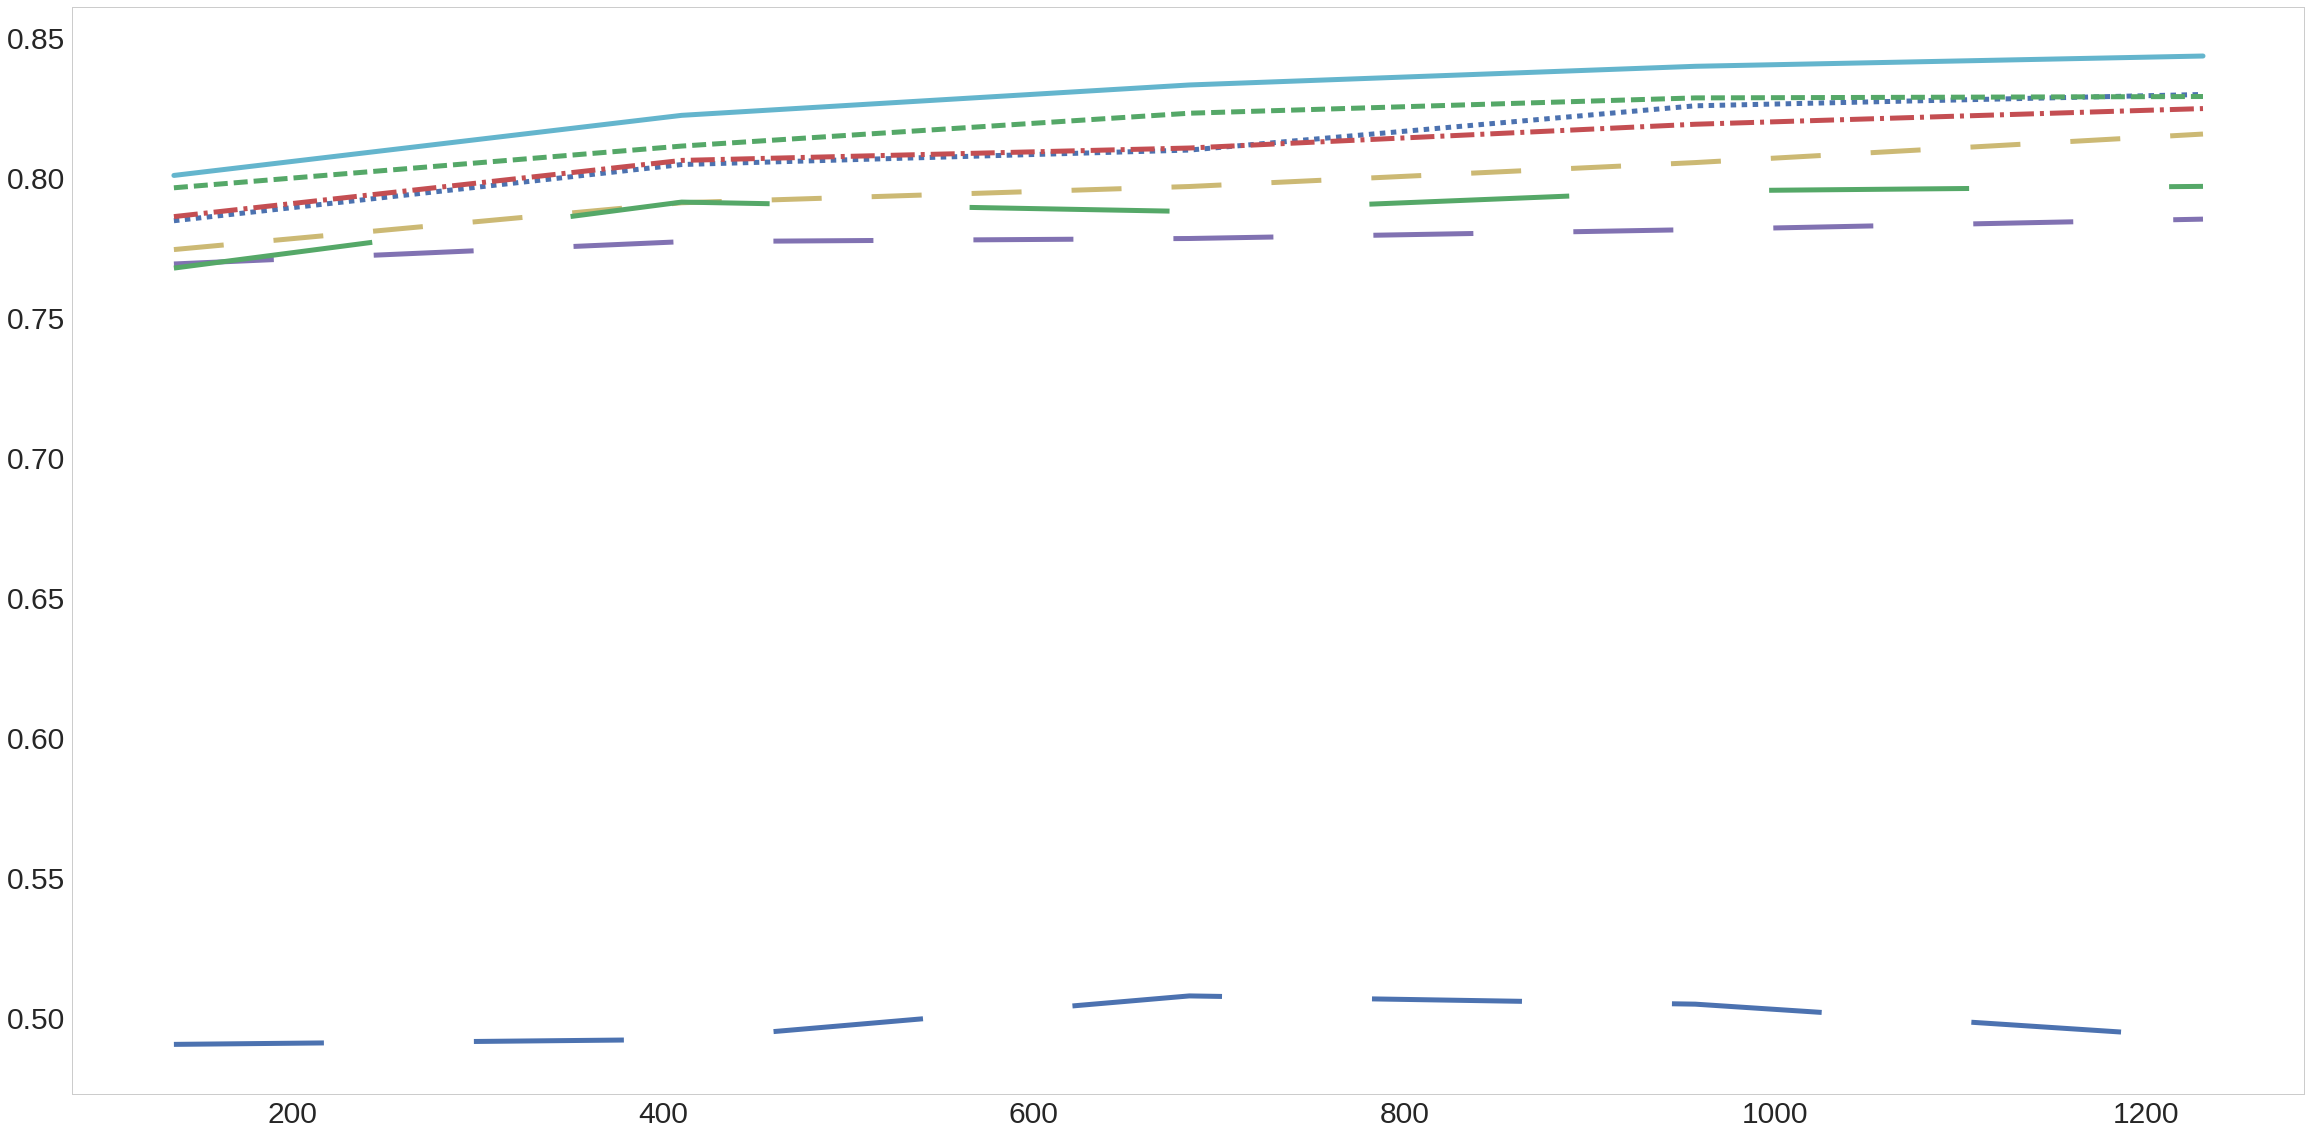

In [43]:
set_plt_params()
results = []

for X, name, lstyle in [(glove_vectors, 'Glove', 'dotted'),
                (word2vec_vectors, 'Word2Vec', 'dashed'),
                (wang2vec_vectors, 'Wang2Vec', 'dashdot'),
                (w2vf_vectors, 'Word2Vec-f',  (0, (20,20))),
                (adagram_vectors, 'Adagram', (0,(10,10))),
                (ft_vectors, 'FastText','solid'),
                (bow_vectors, 'Bag of Words',(0,(30,30))),
                (swivel_vectors, 'Swivel',(0,(40,40))),
                ]:
    #estimator = SVC(C = 0.01, kernel = 'linear')
    estimator = KNeighborsClassifier(n_neighbors = 3)
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
    train_sizes=np.linspace(0.1, 0.9, 5)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    results.append({'model' : name, 'score' : train_scores_mean[-1]})
    plt.plot(train_sizes, train_scores_mean, label=name, linewidth=5, linestyle=lstyle)

#plt.legend(loc='lower center', bbox_to_anchor=(1,1), prop={'size':30})
plt.savefig('classifiers.png', bbox_inches='tight')
plt.show()

In [39]:
results

[{'model': 'Glove', 'score': 0.82965069049553219},
 {'model': 'Word2Vec', 'score': 0.82891957757920376},
 {'model': 'Wang2Vec', 'score': 0.82461413484971557},
 {'model': 'Word2Vec-f', 'score': 0.78513403736799359},
 {'model': 'Adagram', 'score': 0.81551584077985384},
 {'model': 'FastText', 'score': 0.84337936636880584},
 {'model': 'Bag of Words', 'score': 0.49293257514216082},
 {'model': 'Swivel', 'score': 0.79683184402924445}]